In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


--- Generating Trajectory Dataset (64x64) ---


Generating trajectories: 100%|██████████| 20000/20000 [03:31<00:00, 94.36it/s] 


Successfully generated and saved dataset to 'heat_trajectories_train_64.h5'

--- Verifying Trajectory Data from 'heat_trajectories_train_64.h5' ---
Plotting trajectory for sample 13601 with alpha = 0.0640
Verification plot saved to 'verification_trajectory_heat_trajectories_train_64.h5.png'


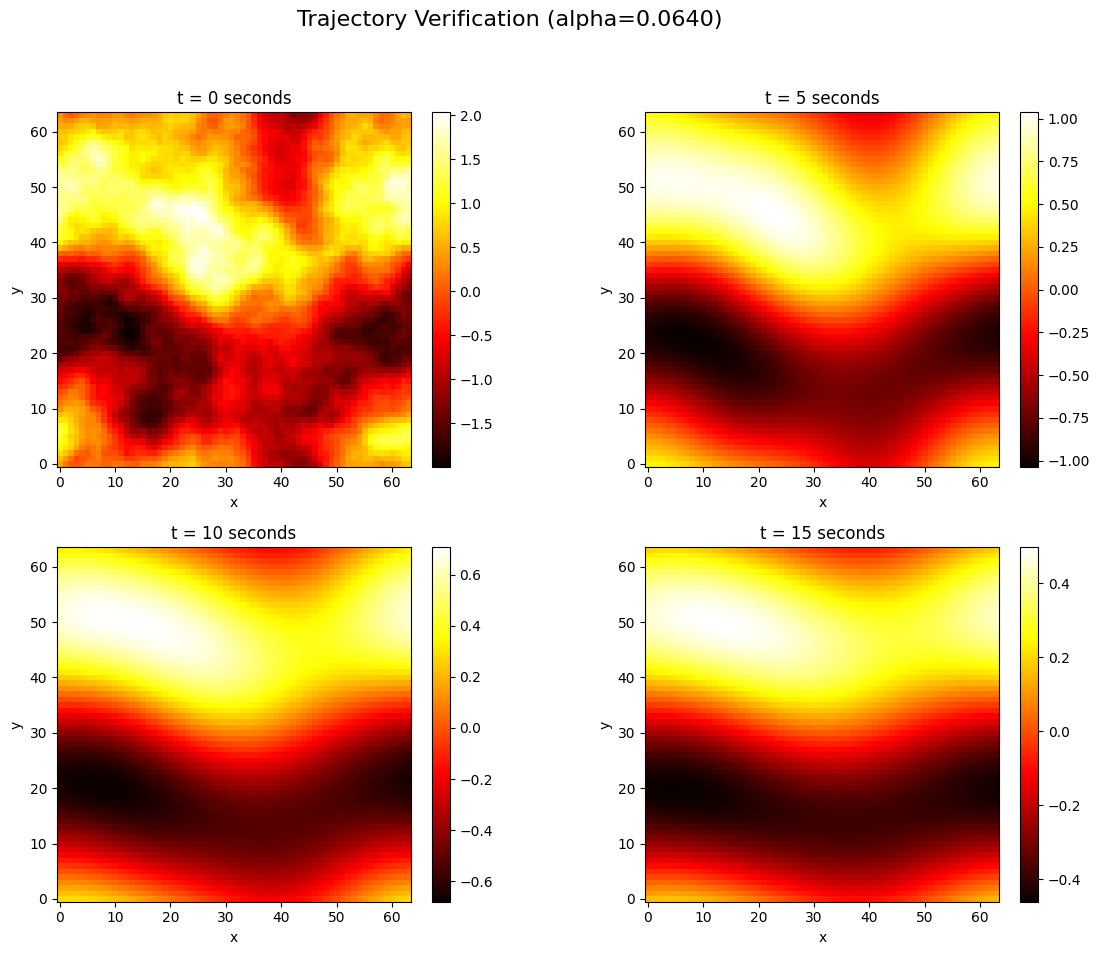


Generating Test Set and Calculating Numerical Solver Benchmark Time...

--- Generating Trajectory Dataset (64x64) ---


Generating trajectories: 100%|██████████| 4000/4000 [00:42<00:00, 94.39it/s]


Successfully generated and saved dataset to 'heat_trajectories_test_64.h5'

--- Numerical Solver Benchmark Results ---
Total time to generate 4000 test trajectories: 42.39 seconds
Average time per trajectory (Your Benchmark): 0.0106 seconds

--- Verifying Trajectory Data from 'heat_trajectories_test_64.h5' ---
Plotting trajectory for sample 1975 with alpha = 0.0983
Verification plot saved to 'verification_trajectory_heat_trajectories_test_64.h5.png'


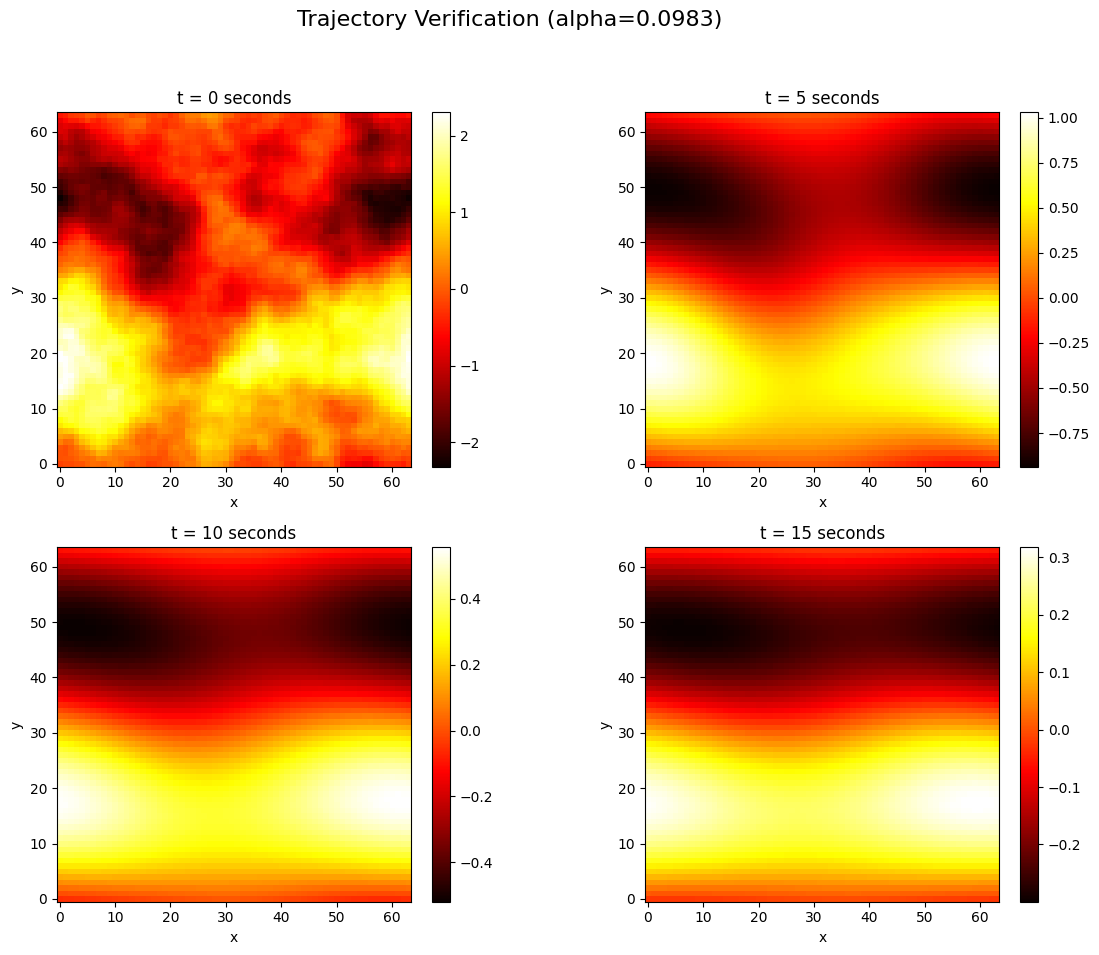

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time

# --- Helper Function to Generate Initial Conditions ---

def generate_grf(size, alpha=2.0, tau=7.0):
    """
    Generates a Gaussian Random Field (GRF) as a smooth, random initial condition.
    """
    k_x = np.fft.fftfreq(size, d=1/size)
    k_y = np.fft.fftfreq(size, d=1/size)
    K_x, K_y = np.meshgrid(k_x, k_y)
    K_squared = K_x**2 + K_y**2
    K_squared[0, 0] = 1.0  # Avoid division by zero
    
    # Generate random phases and amplitudes in Fourier space
    phi = np.random.uniform(0, 2 * np.pi, size=(size, size))
    f_hat = np.exp(1j * phi) * (K_squared)**(-alpha / 2)
    f_hat[0, 0] = 0.0
    
    # Transform back to real space and normalize
    u_0 = np.fft.ifft2(f_hat).real
    u_0 = (u_0 - np.mean(u_0)) / np.std(u_0)
    return u_0

# --- Main Trajectory Generation Function (Corrected) ---

def generate_heat_trajectories(size, num_samples, T_max, dt, alpha_range, filepath):
    """
    Generates a dataset of 2D heat equation trajectories with varying alpha.
    """
    print(f"\n--- Generating Trajectory Dataset ({size}x{size}) ---")
    if os.path.exists(filepath):
        print(f"Dataset file '{filepath}' already exists. Deleting and regenerating.")
        os.remove(filepath)

    num_steps = int(T_max / dt) + 1  # Number of snapshots (t=0, 1, ..., T_max)

    with h5py.File(filepath, 'w') as f:
        # Create datasets
        f.create_dataset('trajectories', (num_samples, num_steps, size, size), dtype='f4')
        f.create_dataset('alphas', (num_samples,), dtype='f4')

        # Store all metadata for reproducibility
        f.attrs['size'] = size
        f.attrs['num_samples'] = num_samples # This attribute is now correctly saved
        f.attrs['T_max'] = T_max
        f.attrs['dt'] = dt
        f.attrs['alpha_min'] = alpha_range[0]
        f.attrs['alpha_max'] = alpha_range[1]

        # Get wavenumbers for the spectral solver
        k_x = np.fft.fftfreq(size, d=1/size)
        k_y = np.fft.fftfreq(size, d=1/size)
        K_x, K_y = np.meshgrid(k_x, k_y)
        K_squared = K_x**2 + K_y**2

        for i in tqdm(range(num_samples), desc=f"Generating trajectories"):
            # Sample a new alpha for this trajectory
            alpha = np.random.uniform(alpha_range[0], alpha_range[1])
            f['alphas'][i] = alpha

            # Generate a random initial condition
            u_0 = generate_grf(size)
            u_0_hat = np.fft.fft2(u_0)
            
            # Store the initial condition (t=0)
            f['trajectories'][i, 0, :, :] = u_0

            # Solve for all future time steps
            for t_idx, t in enumerate(range(dt, T_max + dt, dt), 1):
                u_t_hat = u_0_hat * np.exp(-alpha * K_squared * t)
                u_t = np.fft.ifft2(u_t_hat).real
                f['trajectories'][i, t_idx, :, :] = u_t
                
    print(f"Successfully generated and saved dataset to '{filepath}'")

# --- Verification and Plotting Function (Robust Version) ---

def verify_trajectory(filepath, sample_index=None):
    """Loads and plots a full trajectory to verify the data."""
    print(f"\n--- Verifying Trajectory Data from '{filepath}' ---")
    try:
        with h5py.File(filepath, 'r') as f:
            # Robustly get the number of samples from the dataset shape
            num_samples_in_file = f['trajectories'].shape[0]
            if sample_index is None:
                sample_index = np.random.randint(0, num_samples_in_file)
            
            traj = f['trajectories'][sample_index]
            alpha = f['alphas'][sample_index]
            T_max = f.attrs['T_max']

            print(f"Plotting trajectory for sample {sample_index} with alpha = {alpha:.4f}")

            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            fig.suptitle(f"Trajectory Verification (alpha={alpha:.4f})", fontsize=16)
            
            time_points_to_plot = [0, T_max // 3, 2 * T_max // 3, T_max]

            for i, t in enumerate(time_points_to_plot):
                ax = axes.flat[i]
                im = ax.imshow(traj[t], cmap='hot', origin='lower')
                ax.set_title(f"t = {t} seconds")
                ax.set_xlabel("x")
                ax.set_ylabel("y")
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plot_filename = f"verification_trajectory_{os.path.basename(filepath)}.png"
            plt.savefig(plot_filename)
            print(f"Verification plot saved to '{plot_filename}'")
            plt.show()

    except Exception as e:
        print(f"An error occurred during verification: {e}")

# --- Main Execution Block ---

if __name__ == "__main__":
    # --- Parameters for our scaled-up plan ---
    NUM_TRAIN_SAMPLES = 20000
    NUM_TEST_SAMPLES = 4000
    GRID_SIZE = 64
    ALPHA_RANGE = (0.01, 0.1)
    T_MAX = 15
    DT = 1
    FILEPATH_TRAIN = 'heat_trajectories_train_64.h5'
    FILEPATH_TEST = 'heat_trajectories_test_64.h5'

    # --- Generate Training Data ---
    generate_heat_trajectories(
        size=GRID_SIZE, num_samples=NUM_TRAIN_SAMPLES, T_max=T_MAX,
        dt=DT, alpha_range=ALPHA_RANGE, filepath=FILEPATH_TRAIN
    )
    verify_trajectory(FILEPATH_TRAIN)

    # --- Generate Test Data & Calculate Benchmark Time ---
    print("\n" + "="*50)
    print("Generating Test Set and Calculating Numerical Solver Benchmark Time...")
    print("="*50)

    start_time = time.time()
    generate_heat_trajectories(
        size=GRID_SIZE, num_samples=NUM_TEST_SAMPLES, T_max=T_MAX,
        dt=DT, alpha_range=ALPHA_RANGE, filepath=FILEPATH_TEST
    )
    end_time = time.time()
    
    total_time = end_time - start_time
    time_per_sample = total_time / NUM_TEST_SAMPLES
    
    print("\n--- Numerical Solver Benchmark Results ---")
    print(f"Total time to generate {NUM_TEST_SAMPLES} test trajectories: {total_time:.2f} seconds")
    print(f"Average time per trajectory (Your Benchmark): {time_per_sample:.4f} seconds")
    print("="*42)

    verify_trajectory(FILEPATH_TEST)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import time

# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# --- 1. FNO Model Definition (Building from Scratch) ---

class SpectralConv2d(nn.Module):
    """2D Fourier layer. It does FFT, linear transform, and Inverse FFT."""
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)

        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = torch.einsum("bixy,ioxy->boxy", x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = torch.einsum("bixy,ioxy->boxy", x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO_autoregressive(nn.Module):
    """The FNO model adapted for autoregressive, physics-informed prediction."""
    def __init__(self, modes1, modes2, width):
        super(FNO_autoregressive, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        
        # The input has 4 channels: u(t), grid_x, grid_y, and alpha
        self.p = nn.Linear(4, self.width)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.q = nn.Linear(self.width, 1)

    def forward(self, x, alpha):
        grid = self.get_grid(x.shape, x.device)
        
        # Add alpha as a channel
        alpha_channel = torch.ones_like(grid[..., :1]) * alpha.view(-1, 1, 1, 1)
        
        x = torch.cat((x, grid, alpha_channel), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.q(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

# --- 2. Data Loading for Autoregressive Training ---

class TrajectoryDataset(Dataset):
    """
    Custom Dataset class for loading trajectory data.
    It creates pairs of (u_t, u_{t+1}) for one-step-ahead prediction.
    """
    def __init__(self, filepath):
        self.filepath = filepath
        with h5py.File(self.filepath, 'r') as f:
            self.num_trajectories, self.num_steps = f['trajectories'].shape[:2]
        
        # Total number of samples is (num_trajectories * (num_steps - 1))
        self.num_samples = self.num_trajectories * (self.num_steps - 1)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Calculate which trajectory and which time step this index corresponds to
        trajectory_idx = idx // (self.num_steps - 1)
        time_step_idx = idx % (self.num_steps - 1)
        
        with h5py.File(self.filepath, 'r') as f:
            u_t = f['trajectories'][trajectory_idx, time_step_idx, :, :]
            u_t_plus_1 = f['trajectories'][trajectory_idx, time_step_idx + 1, :, :]
            alpha = f['alphas'][trajectory_idx]

        u_t_tensor = torch.tensor(u_t, dtype=torch.float).unsqueeze(-1)
        u_t_plus_1_tensor = torch.tensor(u_t_plus_1, dtype=torch.float).unsqueeze(-1)
        alpha_tensor = torch.tensor(alpha, dtype=torch.float)
        
        return u_t_tensor, u_t_plus_1_tensor, alpha_tensor

# --- 3. Loss Function ---

class LpLoss(object):
    """Lp loss function, used for comparing the relative error."""
    def __init__(self, p=2):
        super(LpLoss, self).__init__()
        self.p = p

    def rel(self, x, y):
        num_examples = x.size(0)
        diff_norms = torch.norm(x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)
        return torch.mean(diff_norms / y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)

# --- 4. Main Training Script ---

if __name__ == "__main__":
    # --- Hyperparameters ---
    MODES = 12
    WIDTH = 20
    BATCH_SIZE = 20
    EPOCHS = 50  # This will likely take several Kaggle sessions
    LEARNING_RATE = 0.001
    
    # --- File Paths ---
    TRAIN_FILEPATH = 'heat_trajectories_train_64.h5'
    CHECKPOINT_FILE = 'fno_autoregressive_checkpoint.pth'

    # --- Setup DataLoaders ---
    print("Setting up DataLoaders...")
    train_dataset = TrajectoryDataset(TRAIN_FILEPATH)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    print(f"Total training samples (one-step pairs): {len(train_dataset)}")

    # --- Setup Model and Optimizer ---
    model = FNO_autoregressive(modes1=MODES, modes2=MODES, width=WIDTH).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    loss_fn = LpLoss()

    # --- Check for Checkpoint to Resume Training ---
    start_epoch = 0
    if os.path.exists(CHECKPOINT_FILE):
        print(f"Resuming training from checkpoint: {CHECKPOINT_FILE}")
        checkpoint = torch.load(CHECKPOINT_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming from epoch {start_epoch + 1}")

    # --- Training Loop ---
    print("\n--- Starting Training ---")
    for epoch in range(start_epoch, EPOCHS):
        model.train()
        epoch_loss = 0
        epoch_start_time = time.time()
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for u_t, u_t_plus_1, alpha in pbar:
            u_t, u_t_plus_1, alpha = u_t.to(DEVICE), u_t_plus_1.to(DEVICE), alpha.to(DEVICE)
            
            optimizer.zero_grad()
            
            # The model predicts the next step
            pred_u_t_plus_1 = model(u_t, alpha)
            
            loss = loss_fn(pred_u_t_plus_1.squeeze(), u_t_plus_1.squeeze())
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            
        avg_epoch_loss = epoch_loss / len(train_loader)
        epoch_end_time = time.time()
        
        print(f"Epoch {epoch+1} Summary | Avg Loss: {avg_epoch_loss:.6f} | Time: {epoch_end_time - epoch_start_time:.2f}s")

        # --- Save Checkpoint After Every Epoch ---
        print("Saving checkpoint...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }, CHECKPOINT_FILE)
        print(f"Checkpoint saved to {CHECKPOINT_FILE}")

    print("\n--- Training Complete ---")

Using device: cuda
Setting up DataLoaders...
Total training samples (one-step pairs): 300000

--- Starting Training ---


Epoch 1/50: 100%|██████████| 15000/15000 [04:49<00:00, 51.77it/s, loss=0.0102] 


Epoch 1 Summary | Avg Loss: 0.012670 | Time: 289.76s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 2/50: 100%|██████████| 15000/15000 [04:44<00:00, 52.75it/s, loss=0.00317]


Epoch 2 Summary | Avg Loss: 0.006488 | Time: 284.34s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 3/50: 100%|██████████| 15000/15000 [04:45<00:00, 52.61it/s, loss=0.00289]


Epoch 3 Summary | Avg Loss: 0.005741 | Time: 285.10s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 4/50: 100%|██████████| 15000/15000 [04:44<00:00, 52.69it/s, loss=0.00551]


Epoch 4 Summary | Avg Loss: 0.005211 | Time: 284.70s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 5/50: 100%|██████████| 15000/15000 [04:44<00:00, 52.72it/s, loss=0.0049] 


Epoch 5 Summary | Avg Loss: 0.004908 | Time: 284.53s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 6/50: 100%|██████████| 15000/15000 [04:45<00:00, 52.53it/s, loss=0.00355]


Epoch 6 Summary | Avg Loss: 0.004670 | Time: 285.57s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 7/50: 100%|██████████| 15000/15000 [04:45<00:00, 52.53it/s, loss=0.003]  


Epoch 7 Summary | Avg Loss: 0.004524 | Time: 285.54s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 8/50: 100%|██████████| 15000/15000 [04:43<00:00, 52.86it/s, loss=0.00262]


Epoch 8 Summary | Avg Loss: 0.004281 | Time: 283.77s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 11/50: 100%|██████████| 15000/15000 [04:44<00:00, 52.72it/s, loss=0.00269]


Epoch 11 Summary | Avg Loss: 0.003885 | Time: 284.54s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 15/50: 100%|██████████| 15000/15000 [04:44<00:00, 52.81it/s, loss=0.00224]


Epoch 15 Summary | Avg Loss: 0.003600 | Time: 284.06s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 18/50: 100%|██████████| 15000/15000 [04:43<00:00, 52.91it/s, loss=0.0037] 


Epoch 18 Summary | Avg Loss: 0.003419 | Time: 283.51s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 22/50: 100%|██████████| 15000/15000 [04:45<00:00, 52.55it/s, loss=0.00178]


Epoch 22 Summary | Avg Loss: 0.003288 | Time: 285.47s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 25/50: 100%|██████████| 15000/15000 [04:46<00:00, 52.43it/s, loss=0.0026] 


Epoch 25 Summary | Avg Loss: 0.003181 | Time: 286.10s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 30/50: 100%|██████████| 15000/15000 [04:44<00:00, 52.67it/s, loss=0.00249]


Epoch 30 Summary | Avg Loss: 0.003082 | Time: 284.81s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 34/50: 100%|██████████| 15000/15000 [04:44<00:00, 52.79it/s, loss=0.00377]


Epoch 34 Summary | Avg Loss: 0.003013 | Time: 284.13s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 38/50: 100%|██████████| 15000/15000 [04:46<00:00, 52.38it/s, loss=0.00309] 


Epoch 38 Summary | Avg Loss: 0.002921 | Time: 286.37s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 43/50: 100%|██████████| 15000/15000 [04:44<00:00, 52.80it/s, loss=0.00232]


Epoch 43 Summary | Avg Loss: 0.002874 | Time: 284.10s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 47/50: 100%|██████████| 15000/15000 [04:46<00:00, 52.44it/s, loss=0.00344]


Epoch 47 Summary | Avg Loss: 0.002826 | Time: 286.03s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 48/50:  19%|█▊        | 2787/15000 [00:53<03:50, 52.87it/s, loss=0.00273]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
NotebookApp.rate_limit_window=1.0 (secs)

Epoch 48/50: 100%|██████████| 15000/15000 [04:44<00:00, 52.80it/s, loss=0.00212]


Epoch 48 Summary | Avg Loss: 0.002825 | Time: 284.11s
Saving checkpoint...
Checkpoint saved to fno_autoregressive_checkpoint.pth


Epoch 49/50:  44%|████▍     | 6580/15000 [02:04<02:38, 53.18it/s, loss=0.00362] 

Using device: cuda
Loading trained model from fno_autoregressive_checkpoint.pth...
Model loaded successfully.

--- Starting Full Benchmark on Test Set ---


Benchmarking FNO Rollouts: 100%|██████████| 4000/4000 [02:39<00:00, 25.01it/s]



--- FNO Inference Benchmark Results ---
Total time to predict 4000 test trajectories: 159.91 seconds
Average time per trajectory (FNO Inference): 0.0400 seconds
Average Relative Error on Test Set: 0.011479

--- Generating Visualization Plots ---
Rollout comparison plot saved to 'fno_rollout_comparison_sample_10.png'


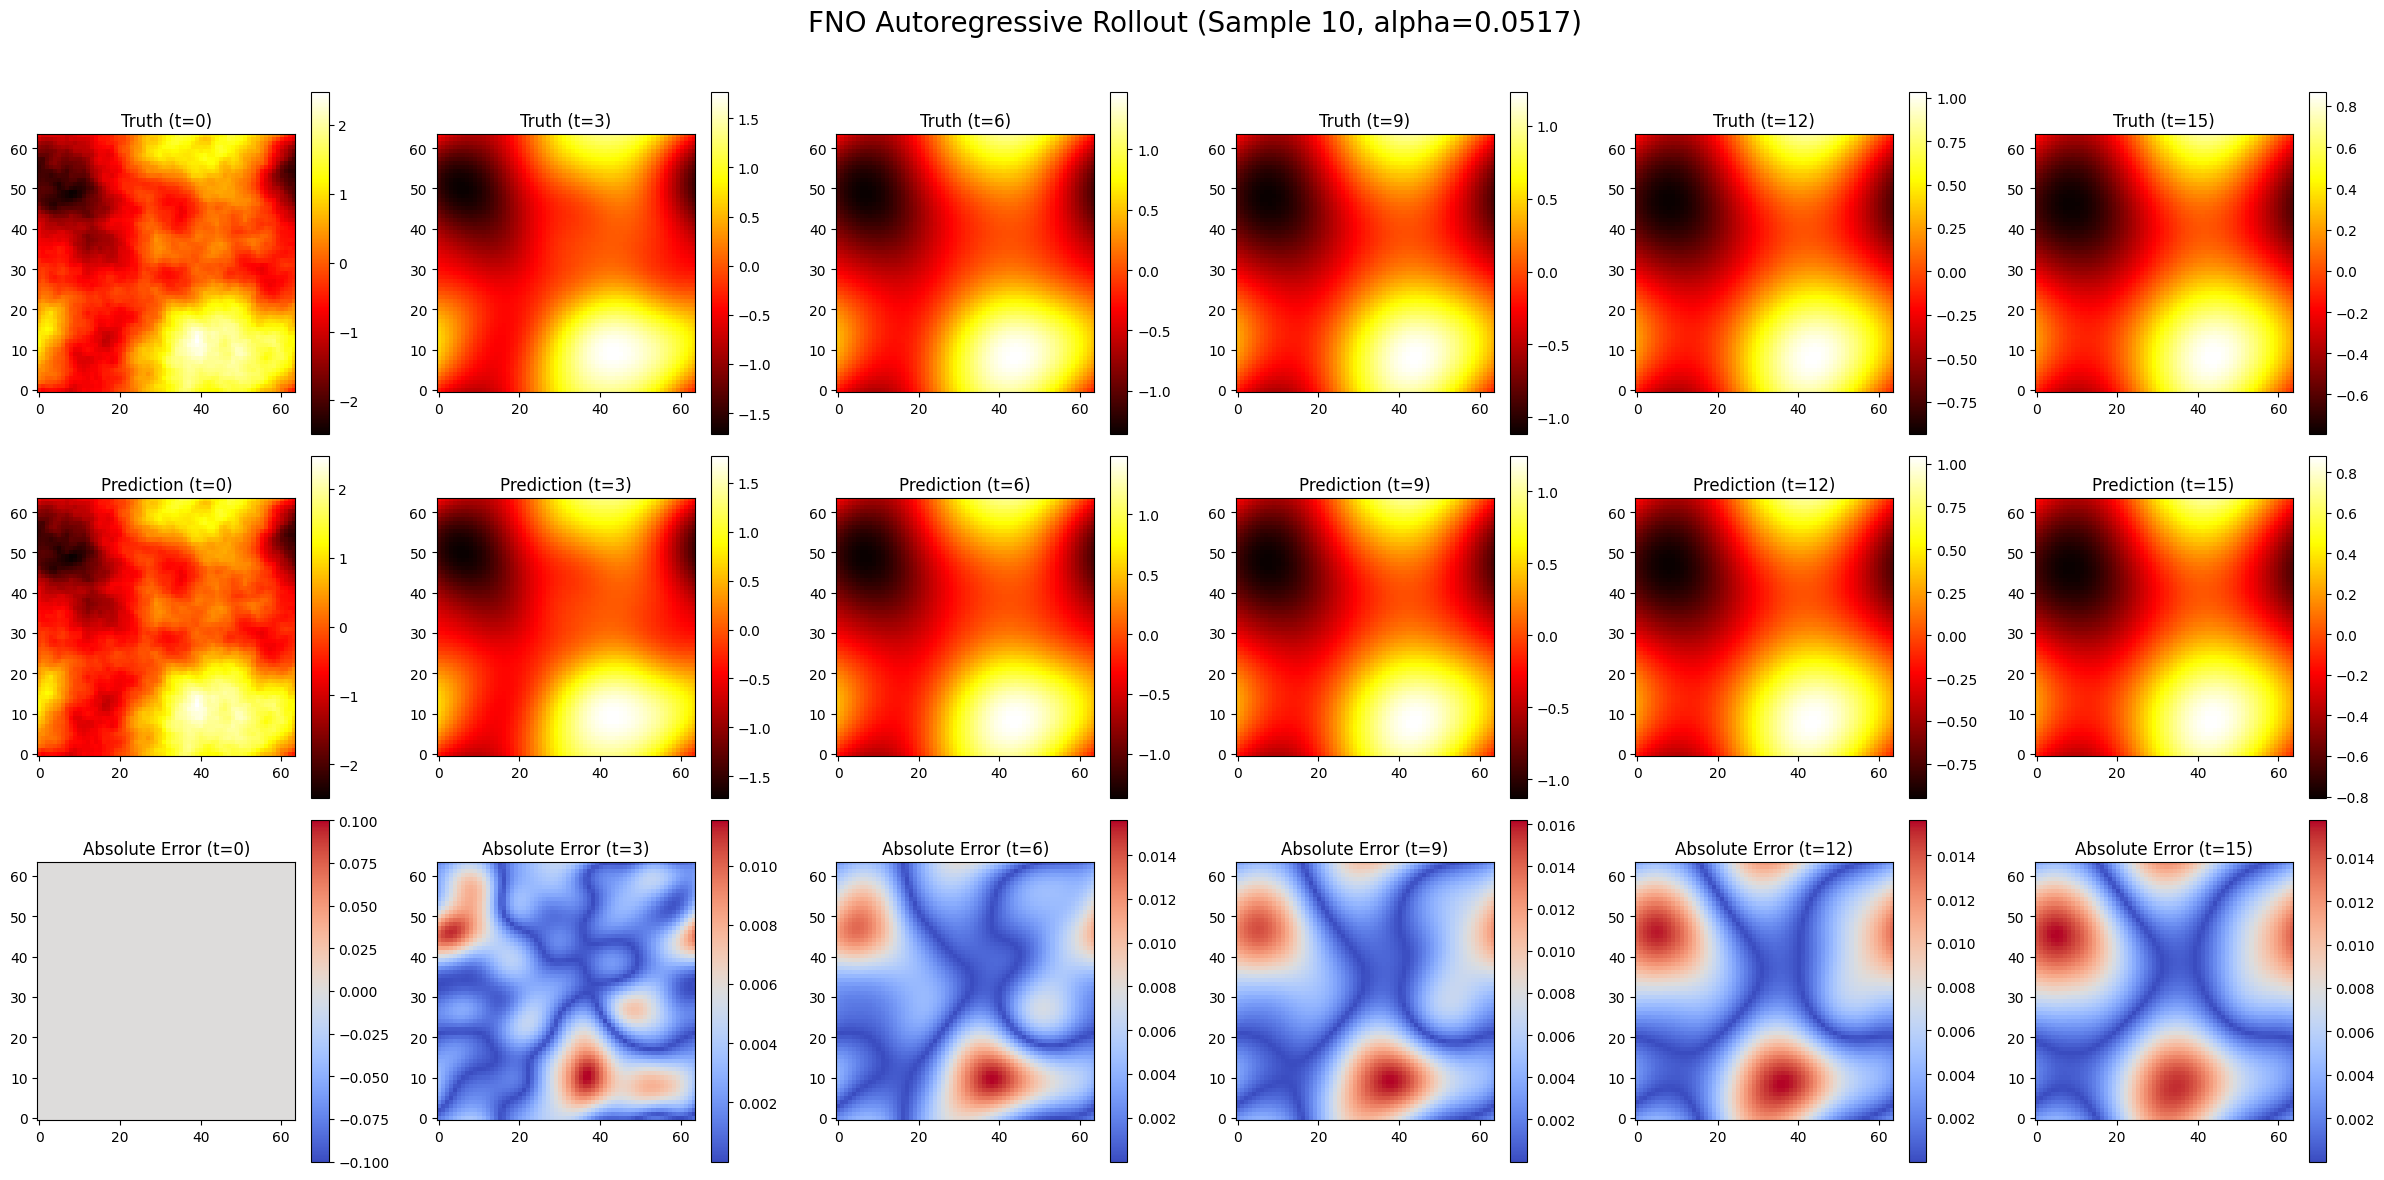

Rollout comparison plot saved to 'fno_rollout_comparison_sample_25.png'


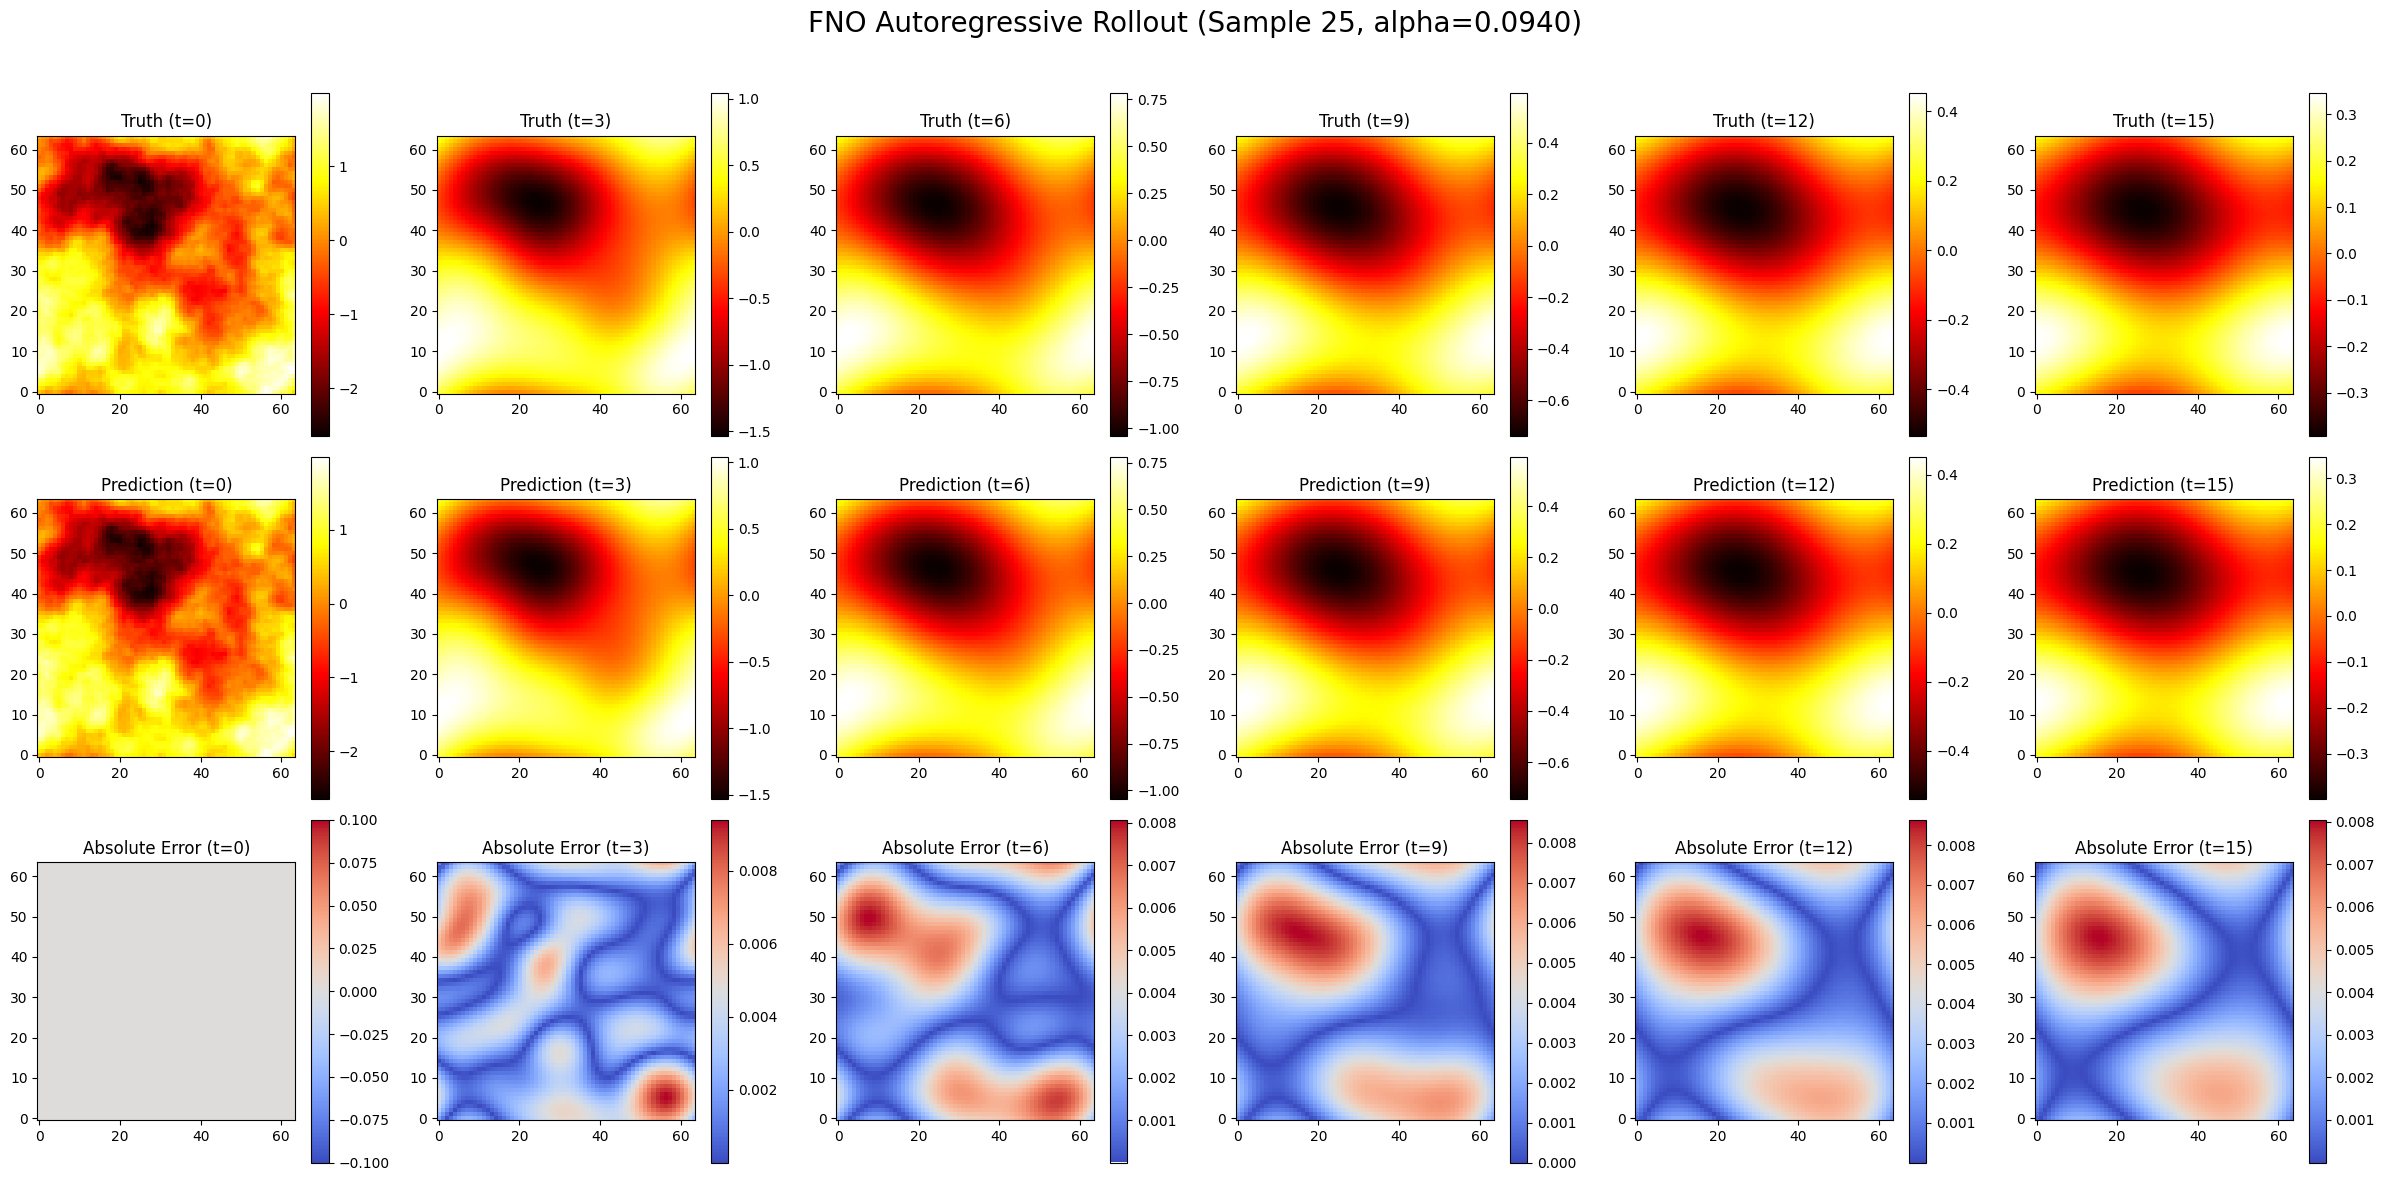

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import time

# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# --- 1. Re-define Model and Loss for Loading ---
# We need to define the classes again so PyTorch knows how to load the model checkpoint

class SpectralConv2d(nn.Module):
    """2D Fourier layer. It does FFT, linear transform, and Inverse FFT."""
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.modes1, self.modes2 = modes1, modes2
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = torch.einsum("bixy,ioxy->boxy", x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = torch.einsum("bixy,ioxy->boxy", x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO_autoregressive(nn.Module):
    """The FNO model adapted for autoregressive, physics-informed prediction."""
    def __init__(self, modes1, modes2, width):
        super(FNO_autoregressive, self).__init__()
        self.modes1, self.modes2, self.width = modes1, modes2, width
        self.p = nn.Linear(4, self.width)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.q = nn.Linear(self.width, 1)

    def forward(self, x, alpha):
        grid = self.get_grid(x.shape, x.device)
        alpha_channel = torch.ones_like(grid[..., :1]) * alpha.view(-1, 1, 1, 1)
        x = torch.cat((x, grid, alpha_channel), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
        x1 = self.conv1(x); x2 = self.w1(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv2(x); x2 = self.w2(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv3(x); x2 = self.w3(x); x = x1 + x2; x = F.gelu(x)
        x1 = self.conv4(x); x2 = self.w4(x); x = x1 + x2
        x = x.permute(0, 2, 3, 1)
        x = self.q(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float).reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float).reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

class LpLoss(object):
    """Lp loss function, used for comparing the relative error."""
    def __init__(self, p=2):
        self.p = p
    def rel(self, x, y):
        num_examples = x.size(0)
        diff_norms = torch.norm(x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)
        return torch.mean(diff_norms / y_norms)
    def __call__(self, x, y):
        return self.rel(x, y)

# --- 2. Evaluation Functions ---

def benchmark_fno(model, test_data_path):
    """
    Performs a full autoregressive rollout for all test samples and benchmarks the time.
    """
    print("\n--- Starting Full Benchmark on Test Set ---")
    
    with h5py.File(test_data_path, 'r') as f:
        test_trajectories = torch.tensor(f['trajectories'][:], dtype=torch.float)
        test_alphas = torch.tensor(f['alphas'][:], dtype=torch.float)
    
    num_samples = test_trajectories.shape[0]
    num_steps = test_trajectories.shape[1]
    
    model.eval()
    total_loss = 0
    loss_fn = LpLoss()
    
    start_time = time.time()
    
    with torch.no_grad():
        for i in tqdm(range(num_samples), desc="Benchmarking FNO Rollouts"):
            u_truth_traj = test_trajectories[i].to(DEVICE)
            alpha = test_alphas[i].to(DEVICE)
            
            # Get initial condition
            current_u = u_truth_traj[0].unsqueeze(0).unsqueeze(-1)
            
            predicted_traj = [current_u.squeeze(0)]
            
            # Autoregressive loop
            for t in range(num_steps - 1):
                pred_u = model(current_u, alpha)
                predicted_traj.append(pred_u.squeeze(0))
                current_u = pred_u
            
            predicted_traj = torch.stack(predicted_traj, dim=0)
            total_loss += loss_fn(predicted_traj, u_truth_traj.unsqueeze(-1)).item()
            
    end_time = time.time()
    
    avg_loss = total_loss / num_samples
    total_time = end_time - start_time
    time_per_sample = total_time / num_samples

    print("\n--- FNO Inference Benchmark Results ---")
    print(f"Total time to predict {num_samples} test trajectories: {total_time:.2f} seconds")
    print(f"Average time per trajectory (FNO Inference): {time_per_sample:.4f} seconds")
    print(f"Average Relative Error on Test Set: {avg_loss:.6f}")
    print("="*41)

def visualize_rollout(model, test_data_path, sample_indices):
    """
    Generates and saves plots comparing the ground truth and FNO rollout.
    """
    print("\n--- Generating Visualization Plots ---")
    model.eval()
    with h5py.File(test_data_path, 'r') as f:
        for idx in sample_indices:
            u_truth_traj = torch.tensor(f['trajectories'][idx], dtype=torch.float).to(DEVICE)
            alpha = torch.tensor(f['alphas'][idx], dtype=torch.float).to(DEVICE)
            
            # Perform autoregressive rollout for this one sample
            with torch.no_grad():
                current_u = u_truth_traj[0].unsqueeze(0).unsqueeze(-1)
                predicted_steps = [current_u.squeeze().cpu().numpy()]
                for _ in range(u_truth_traj.shape[0] - 1):
                    pred_u = model(current_u, alpha)
                    predicted_steps.append(pred_u.squeeze().cpu().numpy())
                    current_u = pred_u
            
            # Plotting
            fig, axes = plt.subplots(3, 6, figsize=(24, 12))
            fig.suptitle(f"FNO Autoregressive Rollout (Sample {idx}, alpha={alpha.item():.4f})", fontsize=20)
            
            plot_steps = [0, 3, 6, 9, 12, 15]
            
            for i, t in enumerate(plot_steps):
                # Row 1: Ground Truth
                ax = axes[0, i]
                im = ax.imshow(u_truth_traj[t].cpu().numpy(), cmap='hot', origin='lower')
                ax.set_title(f"Truth (t={t})")
                fig.colorbar(im, ax=ax)
                
                # Row 2: FNO Prediction
                ax = axes[1, i]
                im = ax.imshow(predicted_steps[t], cmap='hot', origin='lower')
                ax.set_title(f"Prediction (t={t})")
                fig.colorbar(im, ax=ax)
                
                # Row 3: Error
                ax = axes[2, i]
                error = np.abs(u_truth_traj[t].cpu().numpy() - predicted_steps[t])
                im = ax.imshow(error, cmap='coolwarm', origin='lower')
                ax.set_title(f"Absolute Error (t={t})")
                fig.colorbar(im, ax=ax)

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plot_filename = f"fno_rollout_comparison_sample_{idx}.png"
            plt.savefig(plot_filename)
            print(f"Rollout comparison plot saved to '{plot_filename}'")
            plt.show()

# --- 3. Main Execution Block ---
if __name__ == "__main__":
    # --- Hyperparameters from Training ---
    MODES = 12
    WIDTH = 20
    
    # --- File Paths ---
    CHECKPOINT_FILE = 'fno_autoregressive_checkpoint.pth'
    TEST_FILEPATH = 'heat_trajectories_test_64.h5'

    if not os.path.exists(CHECKPOINT_FILE) or not os.path.exists(TEST_FILEPATH):
        print("Error: Checkpoint or test data file not found. Please run training first.")
    else:
        # --- Load Trained Model ---
        print(f"Loading trained model from {CHECKPOINT_FILE}...")
        model = FNO_autoregressive(modes1=MODES, modes2=MODES, width=WIDTH).to(DEVICE)
        checkpoint = torch.load(CHECKPOINT_FILE, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded successfully.")
        
        # --- Run Full Benchmark ---
        benchmark_fno(model, TEST_FILEPATH)
        
        # --- Visualize Two Specific Rollouts ---
        visualize_rollout(model, TEST_FILEPATH, sample_indices=[10, 25])

In [ ]:
1==1  

True